In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pyts
from pyts import classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize


In [2]:
# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance)

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")
   

In [3]:
def load_npy(filename):
    return np.load(filename)


In [4]:
# reload 
path = "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/Output/X_y_ids.npz"

X_y_ids = load_npy(path)
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']


In [5]:
#per trasformare in dataframe

df = pd.DataFrame(np.squeeze(X))
df["genre"] = y


In [6]:
y = df.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df.iloc[:, :-1].values
X.shape, y.shape


((10000, 1280), (10000,))

In [7]:
# Inizializza e addestra il LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Crea un dizionario che mappa le classi originali ai loro valori codificati
classi_originali_vs_codificate = dict(zip(y, y_encoded))

# Ora puoi accedere al valore codificato di una classe originale
classe_originale = 'kids'
valore_codificato = classi_originali_vs_codificate[classe_originale]
print(f"Il valore codificato per '{classe_originale}' è: {valore_codificato}")


Il valore codificato per 'kids' è: 7


In [8]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import numpy as np
from tslearn.metrics import dtw


# Definiamo il numero di classi di genere musicale
num_classi = 20

# Inizializziamo un dizionario per memorizzare i centroidi per ciascuna classe di genere musicale
centroidi_per_classe = {}

# Convertiamo le serie temporali in un formato compatibile con tslearn
#X = to_time_series_dataset(X)

# Dividiamo il dataset in subset per ogni classe di genere musicale
for classe in range(num_classi):
    subset_X = X[y_encoded == classe]  # Seleziona solo le serie temporali appartenenti alla classe corrente
    kmeans = TimeSeriesKMeans(n_clusters=1, metric= "euclidean", verbose=0, random_state=42).fit(subset_X)  # Esegui TimeSeriesKMeans con k=1
    centroidi_per_classe[classe] = kmeans.cluster_centers_[0]  # Salva il centroide per la classe corrente

# Inizializziamo una matrice di similarità per memorizzare la similarità tra i centroidi
similarità = np.zeros((num_classi, num_classi))

# Calcoliamo la similarità tra tutti i centroidi utilizzando la distanza euclidea
for i in range(num_classi):
    for j in range(num_classi):
        # Calcoliamo la distanza euclidea tra i centroidi delle classi i e j
        distanza_euclidea = np.linalg.norm(centroidi_per_classe[i] - centroidi_per_classe[j])
        # Memorizziamo la distanza euclidea nella matrice di similarità
        similarità[i][j] = distanza_euclidea


In [9]:
# Troviamo le classi con la massima distanza tra i centroidi
max_distance = np.max(similarità)  # Trova la massima distanza nella matrice di similarità
max_distance_index = np.unravel_index(np.argmax(similarità, axis=None), similarità.shape)  # Trova l'indice della massima distanza

# Ottieni gli indici delle classi con la massima distanza
classe1_index = max_distance_index[0]
classe2_index = max_distance_index[1]

# Stampa le classi con la massima distanza
print("Classi con la massima distanza tra i centroidi:")
print("Classe", classe1_index, "e Classe", classe2_index)


Classi con la massima distanza tra i centroidi:
Classe 3 e Classe 12


In [10]:
# # Ora puoi accedere al valore codificato di una classe originale
# classe_originale = 'emo'
# valore_codificato = classi_originali_vs_codificate[classe_originale]
# print(f"Il valore codificato per '{classe_originale}' è: {valore_codificato}")


a = ['happy', 'emo', 'world-music', 'heavy-metal', 'progressive-house',
       'mpb', 'honky-tonk', 'synth-pop', 'opera', 'piano', 'goth',
       'sertanejo', 'songwriter', 'kids', 'sleep', 'j-idol', 'folk',
       'minimal-techno', 'new-age', 'salsa']


for e in a:
    valore_codificato = classi_originali_vs_codificate[e]
    print(f"Il valore codificato per '{e}' è: {valore_codificato}")


Il valore codificato per 'happy' è: 3
Il valore codificato per 'emo' è: 0
Il valore codificato per 'world-music' è: 19
Il valore codificato per 'heavy-metal' è: 4
Il valore codificato per 'progressive-house' è: 13
Il valore codificato per 'mpb' è: 9
Il valore codificato per 'honky-tonk' è: 5
Il valore codificato per 'synth-pop' è: 18
Il valore codificato per 'opera' è: 11
Il valore codificato per 'piano' è: 12
Il valore codificato per 'goth' è: 2
Il valore codificato per 'sertanejo' è: 15
Il valore codificato per 'songwriter' è: 17
Il valore codificato per 'kids' è: 7
Il valore codificato per 'sleep' è: 16
Il valore codificato per 'j-idol' è: 6
Il valore codificato per 'folk' è: 1
Il valore codificato per 'minimal-techno' è: 8
Il valore codificato per 'new-age' è: 10
Il valore codificato per 'salsa' è: 14


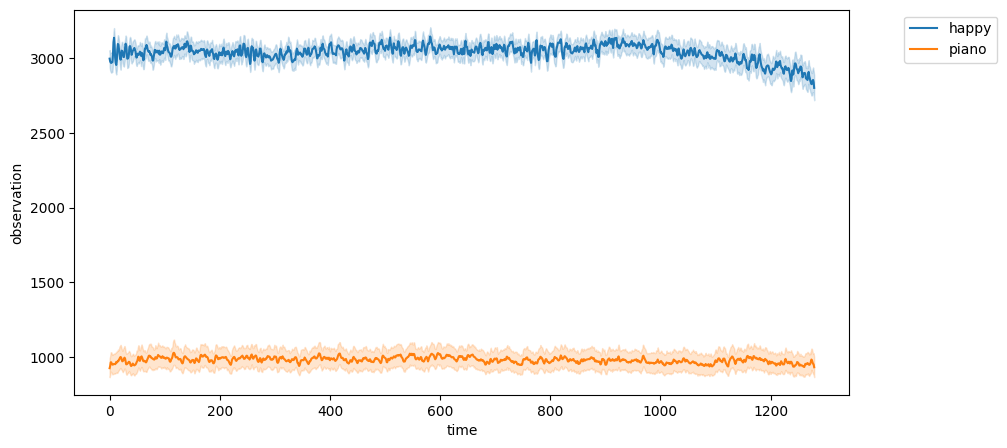

In [11]:
a = ['happy','piano']


plt.figure(figsize=(10, 5))  # Imposta larghezza a 10 pollici e altezza a 6 pollici
#filtro solo per alcuni generi
df_filtered = df[df['genre'].isin(a)] 

df_melt = df_filtered.melt(value_name="observation", var_name="time", id_vars="genre")
#cosi posso osservare ts per x generi scelti dalla target

sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="genre")

# Posiziona la legenda ancora più a destra
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

# Posiziona la legenda sotto il grafico
# plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

plt.show()


# Binary Classification

In [13]:
# reload 
X_y_ids = load_npy(path)
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']


In [14]:
X = X.squeeze()
X.shape


(10000, 1280)

In [15]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

w = 10

for i,time_series in enumerate(X):
    X[i]= moving_average_smoothing(X[i], w)

X


array([[ 464.38378357,  588.41712871,  730.78456307, ..., 1121.54020569,
         993.57362573,  857.56795231],
       [1536.54893036, 1801.66361832, 2051.19784009, ..., 1438.90477859,
        1119.8011977 ,  836.70870164],
       [1091.862005  , 1332.62366156, 1554.36918515, ..., 2703.78425184,
        2381.57394897, 2051.25514757],
       ...,
       [1439.27952856, 1798.35439468, 2137.46808138, ..., 3210.70632654,
        2642.64219789, 2256.21887327],
       [ 792.80298301,  981.73775366, 1151.86570419, ..., 1341.22718811,
        1134.71273879,  933.90420096],
       [ 920.051894  , 1168.70717995, 1500.46220581, ..., 2004.17564244,
        1798.81123347, 1580.41434133]])

In [16]:
#temporaneo 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

print(X.shape)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
X = X.squeeze()
print(X.shape)


(10000, 1280)
(10000, 1280)


In [17]:
df = pd.DataFrame(np.squeeze(X))
df["genre"] = y
df


,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,genre
0,-2.343413,-2.099486,-1.819503,-1.498119,-1.138521,-0.775184,-0.589399,-0.399570,-0.208853,-0.019744,...,-0.571075,-0.521256,-0.490272,-0.503185,-0.517535,-0.787445,-1.051034,-1.302696,-1.570168,opera
1,-0.292995,0.309455,0.876500,1.455743,2.060499,2.680331,2.568858,2.430651,2.284326,2.160694,...,0.533653,0.639138,0.737663,0.803415,0.636957,0.097446,-0.514883,-1.240018,-1.883321,minimal-techno
2,-2.728909,-2.171170,-1.657484,-1.173056,-0.719529,-0.288036,-0.336283,-0.311989,-0.301538,-0.334635,...,0.978971,1.372078,1.792721,2.090109,2.309011,1.705970,1.005204,0.258785,-0.506418,goth
3,-2.838608,-2.474058,-2.119021,-1.745041,-1.360714,-0.971613,-0.929728,-0.912461,-0.902054,-0.866276,...,-1.797375,-1.840443,-1.854840,-1.871490,-1.894380,-2.218737,-2.524970,-2.825002,-3.105079,opera
4,-2.102021,-1.860681,-1.577421,-1.121997,-0.465336,0.173936,-0.053074,-0.293773,-0.603225,-0.853981,...,-0.317422,-0.652662,-1.050538,-1.323230,-1.442989,-1.647507,-1.871939,-2.288233,-2.857996,minimal-techno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-11.837731,-9.743614,-7.536857,-5.252864,-2.827519,-0.314895,0.028640,0.158065,0.122506,0.080244,...,-0.470487,-0.341116,-0.213244,-0.183227,-0.405647,-2.730526,-5.050785,-7.260810,-9.360194,sleep
9996,-2.833799,-2.215091,-1.531750,-0.807893,-0.109174,0.528784,0.669948,0.868346,0.924719,0.976787,...,-0.102220,-0.086275,-0.117112,-0.198692,-0.331971,-0.903529,-1.454614,-1.992289,-2.519455,songwriter
9997,-1.470388,-1.082775,-0.716710,-0.406312,-0.082390,0.278269,0.356705,0.429142,0.520794,0.720048,...,2.385058,2.306237,2.116924,1.886059,1.732837,1.111836,0.441826,-0.171386,-0.588521,kids
9998,-2.062998,-1.878623,-1.712602,-1.548174,-1.384448,-1.244952,-1.221063,-1.003136,-0.761518,-0.631113,...,0.200925,0.043630,-0.205206,-0.507193,-0.838541,-1.239524,-1.527812,-1.729341,-1.925302,kids


In [18]:
#filtro le due classi
df_filtered = df[(df['genre'] == 'happy') | (df['genre'] == 'piano')]
df_filtered.shape


(1000, 1281)

In [19]:
# Assegna la variabile target
y = df_filtered.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df_filtered.iloc[:, :-1].values


In [20]:
from pyts.approximation import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

print(X.shape)
#-------------------------#-------------------------
window_size = 4
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)
print(X_paa.shape)

#-------------------------#-------------------------
## SAX with 50 symbols and 500 segments - erano quelli che plottando la TS davano risultato migliore
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=500, alphabet_size_avg=n_sax_symbols, scale=True)
X_sax = sax.fit_transform(X)
X_sax = X_sax.squeeze()
print(X_sax.shape)

#-------------------------#-------------------------
n_coefs = 64
dft = DiscreteFourierTransform(n_coefs=n_coefs)
X_dft = dft.fit_transform(X)
print(X_dft.shape)


(1000, 1280)
(1000, 320)


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  warnings.warn(


(1000, 500)
(1000, 64)


# Class with DFT

In [21]:
X_dft

array([[-2.72004641e-14, -4.99377063e+02, -3.61871820e+02, ...,
        -1.07935454e+00, -2.76721310e+01,  8.81905643e+00],
       [-1.24211752e-12, -4.48520413e+02,  1.39482136e+00, ...,
        -2.11997104e+01, -2.13463800e+00, -3.86748330e+00],
       [-4.86277685e-13, -3.11116916e+01,  1.16325973e+02, ...,
         7.64077455e+01,  6.50642958e+01,  1.00235548e+02],
       ...,
       [ 6.66133815e-15,  1.32910661e+02, -4.21250729e+02, ...,
         7.77272827e+00,  8.55344069e+01,  3.23399114e+01],
       [ 3.65041330e-13, -2.35437496e+02,  1.51266513e+02, ...,
        -4.50485921e+01, -1.18827271e+01, -4.54913486e+01],
       [ 2.91322522e-13, -9.29149664e+01, -1.91471906e+02, ...,
        -5.92548467e+01,  8.60433438e+00,  2.65949111e+01]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dft, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((800, 64), (200, 64), (800,), (200,))

In [23]:
from sklearn.neighbors import KNeighborsClassifier  

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/base

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [24]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 2, n_neighbors= 1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))


Accuracy 0.53
F1-score [0.65942029 0.24193548]
              precision    recall  f1-score   support

       happy      0.517     0.910     0.659       100
       piano      0.625     0.150     0.242       100

    accuracy                          0.530       200
   macro avg      0.571     0.530     0.451       200
weighted avg      0.571     0.530     0.451       200



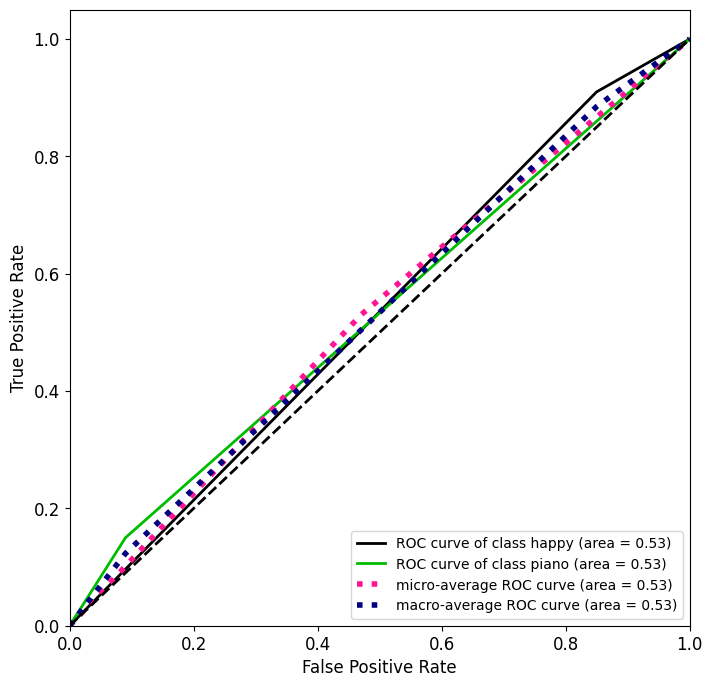

In [25]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()


array([[91,  9],
       [85, 15]])

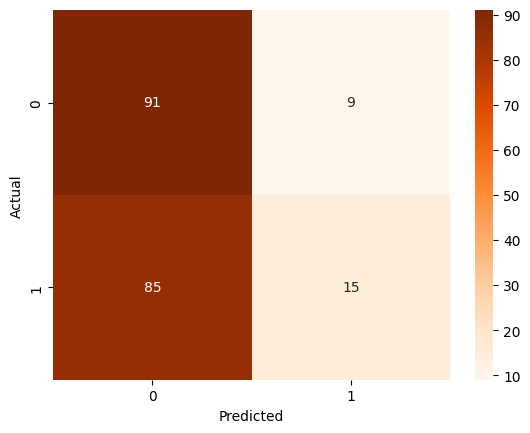

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm


# Classi with PAA

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((800, 320), (200, 320), (800,), (200,))

In [28]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid= param_grid, cv=5 )
grid_search.fit(X_train, y_train)
grid_search.best_params_


/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daviderizzello/Documents/UNIPI/Data_Mining/Progetto_DM2/Notebooks/new_env/lib/python3.11/site-packages/sklearn/base

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [29]:
#cambiare nome modello

#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 1, n_neighbors= 3, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))


Accuracy 0.675
F1-score [0.743083   0.55782313]
              precision    recall  f1-score   support

       happy      0.614     0.940     0.743       100
       piano      0.872     0.410     0.558       100

    accuracy                          0.675       200
   macro avg      0.743     0.675     0.650       200
weighted avg      0.743     0.675     0.650       200



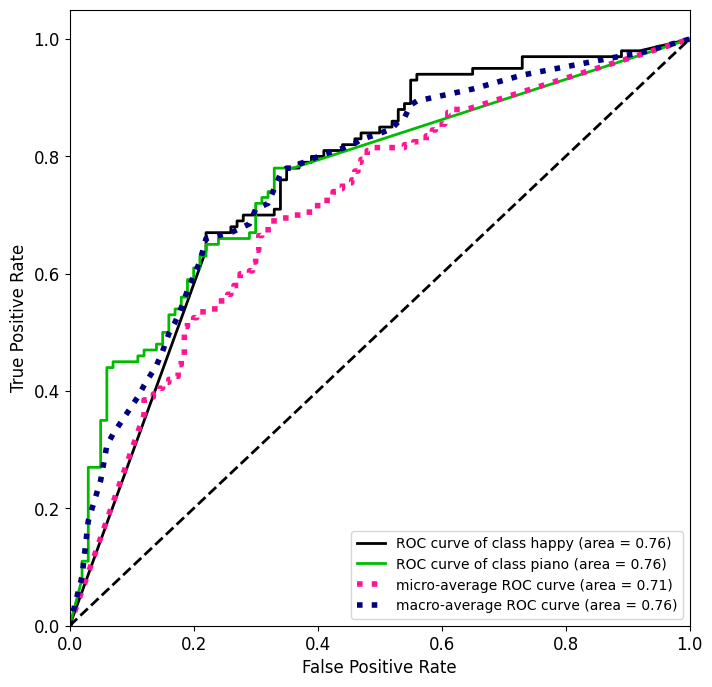

In [30]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()


array([[94,  6],
       [59, 41]])

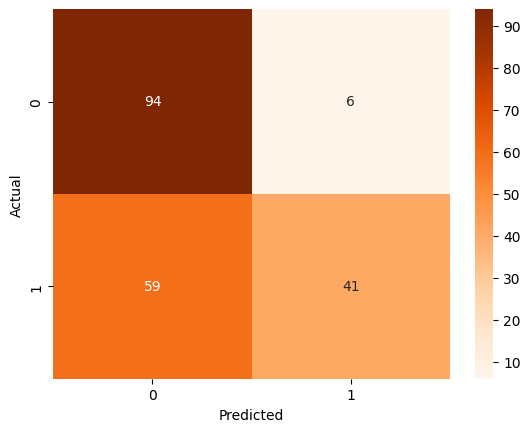

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm


In [32]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    #'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
   # 'metric': ['dtw_fast']  # Metrica per il DTW  'dtw', 'dtw_sakoechiba', 'dtw_itakura', 'dtw_fast
}

knn_dtw = KNeighborsClassifier(metric = 'dtw') 
random_search_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dtw.fit(X_train, y_train)
random_search_dtw.best_params_


CPU times: user 3 μs, sys: 6 μs, total: 9 μs
Wall time: 11 μs


{'weights': 'distance', 'n_neighbors': 15}

In [33]:
#alleno il modello con i migliori parametri:
knn_dtw = KNeighborsClassifier(metric= "dtw", n_neighbors= 15, weights="distance", n_jobs=-1)
knn_dtw.fit(X_train, y_train)

y_pred = knn_dtw.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))


Accuracy 0.805
F1-score [0.77714286 0.82666667]
              precision    recall  f1-score   support

       happy      0.907     0.680     0.777       100
       piano      0.744     0.930     0.827       100

    accuracy                          0.805       200
   macro avg      0.825     0.805     0.802       200
weighted avg      0.825     0.805     0.802       200



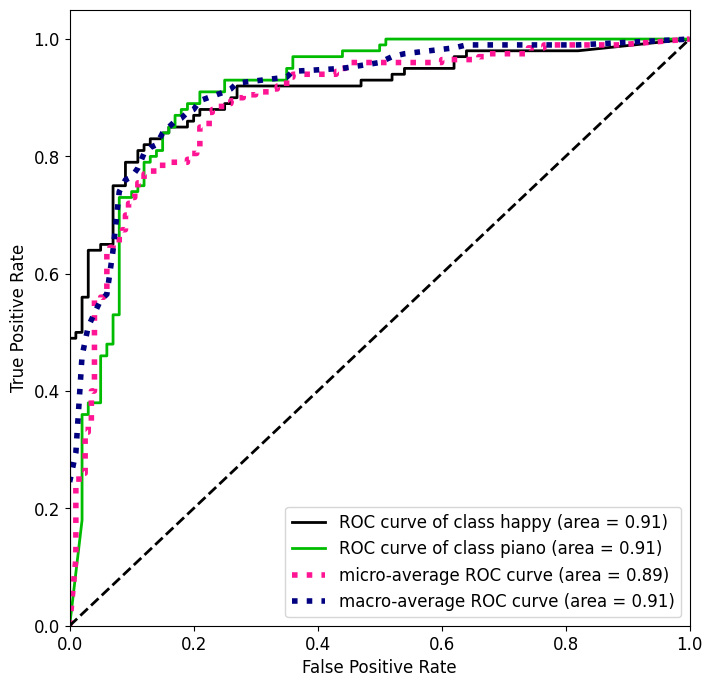

In [34]:
y_score_dtw = knn_dtw.predict_proba(X_test)
plot_roc(y_test, y_score_dtw, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.show()


array([[68, 32],
       [ 7, 93]])

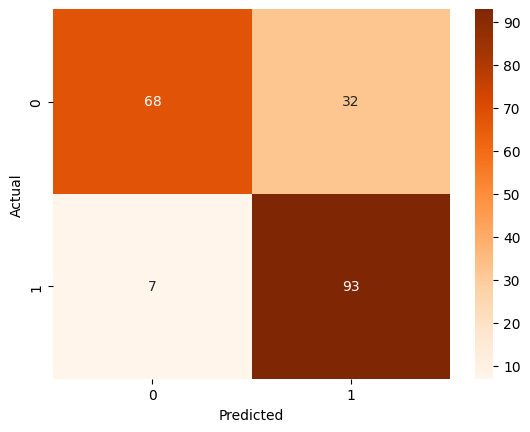

In [35]:
cm_dtw = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dtw, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dtw


# Class with SAX

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sax, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((800, 500), (200, 500), (800,), (200,))

In [37]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_


{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

In [38]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 1, n_neighbors= 1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))


Accuracy 0.65
F1-score [0.6875     0.60227273]
              precision    recall  f1-score   support

       happy      0.621     0.770     0.688       100
       piano      0.697     0.530     0.602       100

    accuracy                          0.650       200
   macro avg      0.659     0.650     0.645       200
weighted avg      0.659     0.650     0.645       200



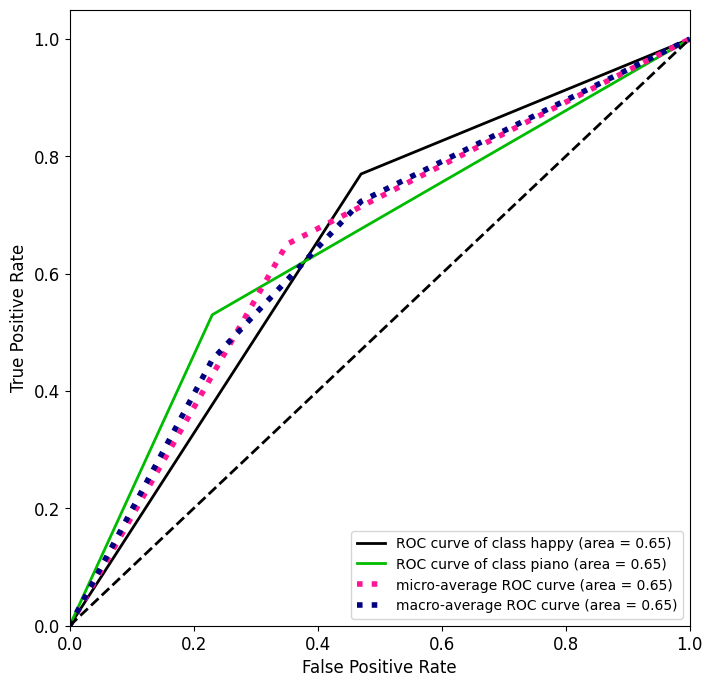

In [39]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()


array([[77, 23],
       [47, 53]])

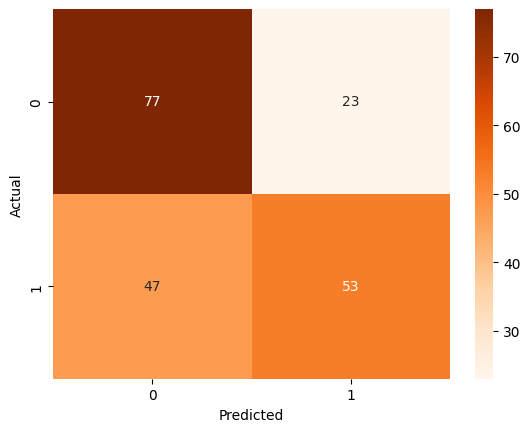

In [40]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm


In [41]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    #'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
   # 'metric': ['dtw_fast']  # Metrica per il DTW  'dtw', 'dtw_sakoechiba', 'dtw_itakura', 'dtw_fast
}

knn_dtw = KNeighborsClassifier(metric = 'dtw') 
random_search_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dtw.fit(X_train, y_train)
random_search_dtw.best_params_


CPU times: user 1e+03 ns, sys: 2 μs, total: 3 μs
Wall time: 6.91 μs


{'weights': 'distance', 'n_neighbors': 15}

In [42]:
knn_dtw = KNeighborsClassifier(metric= "dtw", n_neighbors= 15, weights="distance", n_jobs=-1)
knn_dtw.fit(X_train, y_train)

y_pred = knn_dtw.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))


Accuracy 0.815
F1-score [0.8        0.82790698]
              precision    recall  f1-score   support

       happy      0.871     0.740     0.800       100
       piano      0.774     0.890     0.828       100

    accuracy                          0.815       200
   macro avg      0.822     0.815     0.814       200
weighted avg      0.822     0.815     0.814       200



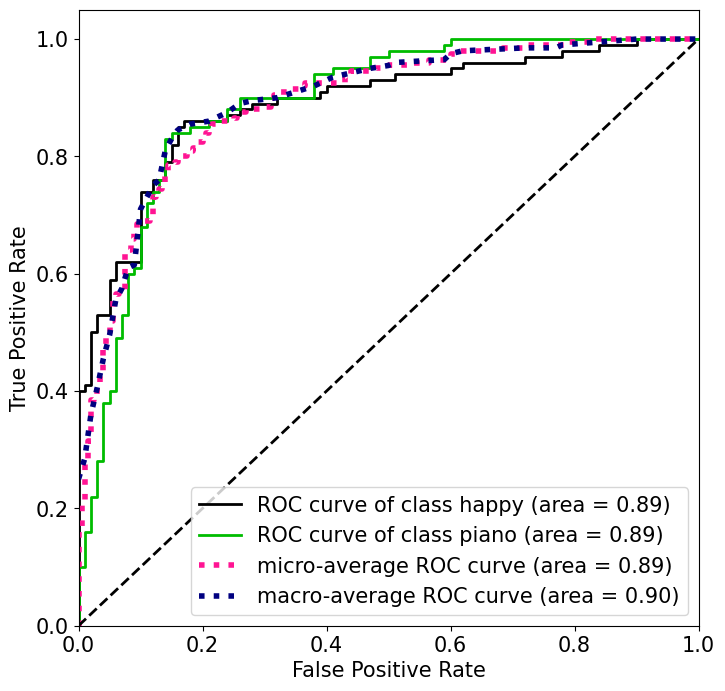

In [43]:
y_score_dtw = knn_dtw.predict_proba(X_test)
plot_roc(y_test, y_score_dtw, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()


array([[74, 26],
       [11, 89]])

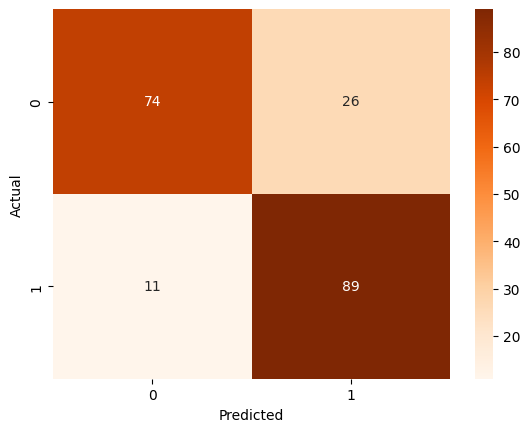

In [44]:
cm_dtw = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dtw, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dtw